In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import yaml

from typing import List, Dict, Any
from pathlib import Path


# local imports
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

In [118]:

da_path = Path(
    '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg')
path_finder = PathFinder(da_path)

path_finder.metrics_paths

[PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/without_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_out_day_experiment_results/metric_results.parquet'),
 PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/with_day_experiment_results/metric_results.parquet')]

In [119]:
metrics_test = path_finder.metrics_paths[1]
feature_test = Path('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_and_d1_only_hyperopt_tune_no_reg/without_day_experiment_results/feature_importance_results.parquet')
feature_analyzer = FeatureImportanceAnalyzer(feature_test)
net_analyzer = MetricAnalyzer(metrics_test)

In [120]:
metrics_test

PosixPath('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_day_experiment_results/metric_results.parquet')

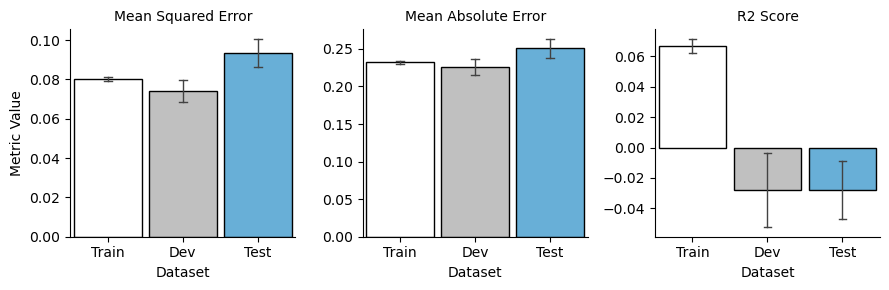

In [121]:
net_analyzer.read_and_clean_data()
net_analyzer.plot_data()

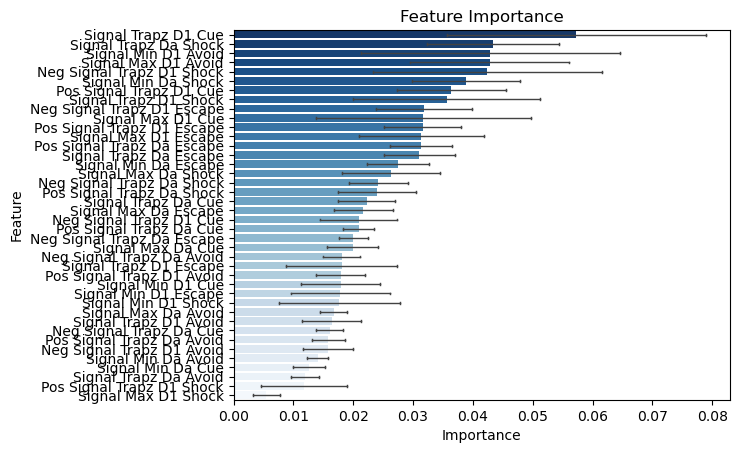

In [122]:
feature_analyzer.read_and_clean_data()
feature_analyzer.plot_data()